# **Introduction to In-Context Learning Demo: Binary Classification**

## **Overview**
This notebook presents a step-by-step walkthrough of an interactive demo that explores how Large Language Models (LLMs) can perform **image-based binary classification purely through in-context learning**. Inspired by the idea that LLMs can function as general pattern recognizers, this experiment uses small image snippets of hazelnuts—labeled as good or bad—to examine how effectively Gemini can internalize visual defect patterns and reproduce consistent judgments on new samples. The goal is to illustrate how an LLM—without explicit training, fine-tuning, or feature engineering—can infer quality cues such as surface texture, cracks, mold, or deformation from a few examples and generalize to unseen hazelnuts. The resulting approach **allows for online and incremental learning of perception** without any gradient-based updates.  

## **Background**
This demo focuses on real hazelnut images categorized into two classes:
- Good hazelnuts: Typically clean, symmetric, and free of surface defects.
- Bad hazelnuts: Containing surface markings, cracks, discoloration, mold, dents, or structural abnormalities.

Each example image serves as an example pairing:
- A compact visual representation
- A binary label: "Good" or "Bad"

What makes this setup particularly compelling:
- The data was checked before utilization to make sure the LLM cannot classify the quality of hazelnuts before ICL.
- The model receives visual examples only through the prompt context
- No training or gradient updates occur—classification arises from pattern matching
- Prompts can include descriptions, annotations, or multi-step chains of examples
- The test images require generalization, not memorization
- Predictions are generated sample-by-sample, mimicking standard evaluation flows

This setting provides a clear benchmark for understanding how well LLMs can perform visual classification tasks when guided only through carefully constructed prompts.

## **Let's Take a Look at an Example**

The illustration below shows good and bad hazelnut examples. Given a set of labeled samples in context, the LLM must determine the correct label for each new, unseen hazelnut image during evaluation.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/binary_classification.png" height="500">

## **LLM as the Classifier**

In this demo, we use Gemini 2.0/2.5 Flash in non-reasoning mode, prompting the model to rely on direct pattern recognition rather than symbolic explanation or analytic reasoning.

The workflow proceeds as follows:
- Provide 10 total labeled hazelnut images (5 good, 5 bad) as in-context examples
- Send a new unlabeled image through the prompt to classify
- Ask the model to output either "Good" or "Bad"

The LLM functions as a lightweight, prompt-driven classifier—absorbing visual differences, structural patterns, and defect signatures from the in-context examples.

## **Evaluation**
Finally, we compare the model’s predicted labels against ground-truth quality labels and accuracy. This provides an insight into how effectively a LLM can approximate visual quality-control decisions through in-context learning alone—without any dedicated training pipeline.

## **Code Overview**
The implementation is structured modularly, with each component handling a distinct stage of the ICL classification pipeline. This separation makes the system easy to modify, extend, and reuse:
- Data loading & preprocessing: Read images, convert to model-compatible format
- Visualization: Display sets of good/bad examples
- Prompt construction: Insert labeled samples into few-shot prompts
- LLM inference: Retrieve predictions one image at a time
- Evaluation: Compute metrics and compare with a baseline (CNN)

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Import Necessary Libraries**
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import re
import itertools
import math
import ast
import json
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
import os
import getpass
import time

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash"),
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

In [ ]:
#@title **Download Data from GitHub**
if not os.path.exists("intro_to_icl_data"):
    !git clone https://github.com/hsiang-fu/intro_to_icl_data.git



Cloning into 'intro_to_icl_data'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 172 (delta 63), reused 115 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 17.23 MiB | 26.82 MiB/s, done.
Resolving deltas: 100% (63/63), done.


The cell `ICL Binary Classification` below  is responsible for running ICL binary hazelnut classification. It loads labeled training examples, constructs the few-shot prompt, sends the prompt to the LLM for each test image, parses the prediction, evaluates correctness, and finally reports overall accuracy.

Each test image is displayed, and the model’s prediction and the ground truth label are printed. Running each cell will perform inference across all test images.

After the cell runs, it performs several steps. First, it builds the ICL training examples by loading ten labeled hazelnut images (five Good and five Bad). Each example is converted into a Gemini Part so it can be embedded directly into the prompt. These form the annotated few-shot demonstrations the model uses to learn the classification pattern. Next, it constructs the full ICL prompt for each test item by including the instruction, all labeled example images, the unlabeled test image, and a rule specifying that the model should respond only with “Good” or “Bad.” Then it loads the unseen test images and their ground-truth labels. For each test image, the cell displays the image, sends the entire ICL prompt to Gemini, reads the model’s label prediction, compares it to the ground truth, and stores the results. After all images are processed, the cell computes summary metrics such as accuracy, total number of correct predictions, and incorrect predictions.

Each evaluation cycle outputs the test hazelnut image, the model’s predicted label, the true label, and whether the prediction was correct. At the end, the code prints a performance summary showing the model’s accuracy across all ten test images.

## **Let's take a look at the prompt**

```
You are an expert in visual inspection.
Based on the examples provided, classify whether the test hazelnut is 'Good' or 'Bad'.

{Example Image: Label Pairs}

What is the condition of the hazelnut? Only return 'Good' or 'Bad'.
```

This prompt shows the model several example image–label pairs of hazelnuts, where each example presents an image of a hazelnut alongside its correct classification label (“Good” or “Bad”). These examples act as demonstrations of the visual criteria that define each category. After providing these labeled examples, the prompt then presents a new unseen and unlabeled test hazelnut and asks the model to classify it based on the pattern it inferred from the examples.

This is considered ICL because the model is not being updated or fine-tuned. All “learning” occurs within the prompt itself: the example image–label pairs serve as the model’s temporary training data. By examining these demonstrations, the model infers the visual characteristics associated with “Good” versus “Bad” hazelnuts and applies that inferred pattern to the test hazelnut during the same forward pass. In other words, the model learns from context, not from parameter updates, which is exactly what defines ICL.


Running Binary Image Classification



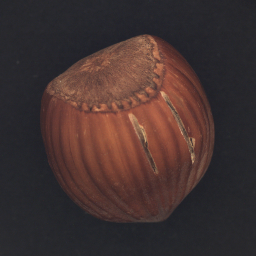


Classifying test1...
LLM Prediction: Bad
Ground Truth: Bad



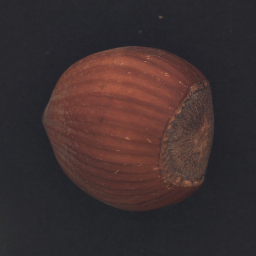


Classifying test2...
LLM Prediction: Good
Ground Truth: Good



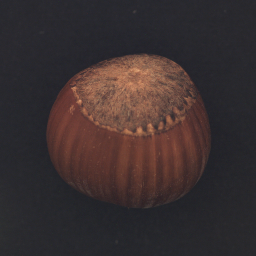


Classifying test3...
LLM Prediction: Good
Ground Truth: Good



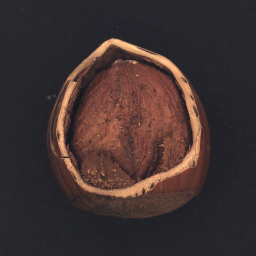


Classifying test4...
LLM Prediction: Bad
Ground Truth: Bad



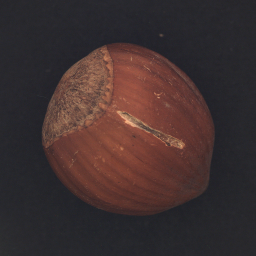


Classifying test5...
LLM Prediction: Bad
Ground Truth: Bad



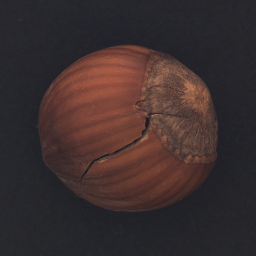


Classifying test6...
LLM Prediction: Bad
Ground Truth: Bad



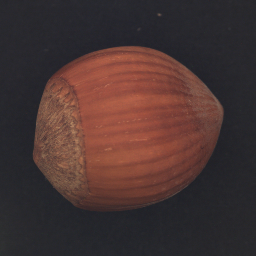


Classifying test7...
LLM Prediction: Good
Ground Truth: Good



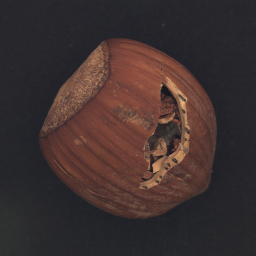


Classifying test8...
LLM Prediction: Bad
Ground Truth: Bad



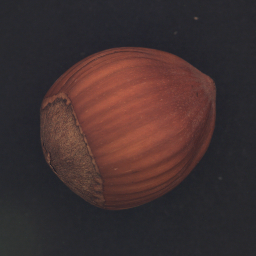


Classifying test9...
LLM Prediction: Good
Ground Truth: Good



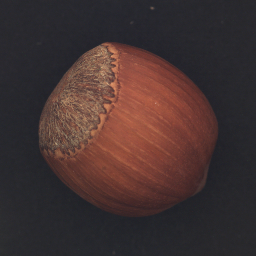


Classifying test10...
LLM Prediction: Good
Ground Truth: Good


=== Model Performance Summary ===
Accuracy: 1.000
Total Samples: 10
Correct: 10
Incorrect: 0


In [ ]:
#@title **ICL Binary Classification**

print("\nRunning Binary Image Classification\n")

test_ground_truth = {
    "test1": "Bad",
    "test2": "Good",
    "test3": "Good",
    "test4": "Bad",
    "test5": "Bad",
    "test6": "Bad",
    "test7": "Good",
    "test8": "Bad",
    "test9": "Good",
    "test10": "Good",
}

test_images = list(test_ground_truth.keys())

model_predictions = []
icl_results = []

train_filenames = [f"good{i}" for i in range(1, 6)] + [f"bad{i}" for i in range(1, 6)]
train_labels = ["Good"] * 5 + ["Bad"] * 5

def load_part(path):
    """Load an image file as a Gemini Part."""
    with open(path, "rb") as f:
        return types.Part.from_bytes(
            data=f.read(),
            mime_type="image/png"
        )

train_parts = [
    load_part(f"intro_to_icl_data/hazelnuts/{name}.png")
    for name in train_filenames
]

def classify_image(selected_label):

    test_path = f"intro_to_icl_data/hazelnuts/{selected_label}.png"
    test_part = load_part(test_path)
    with open(test_path, "rb") as f:
      display(Image(data=f.read()))

    contents = [
        "You are an expert in visual inspection. "
        "Based on the examples provided, classify whether the test hazelnut is 'Good' or 'Bad'.\n"
    ]

    # Add example images as few-shot ICL
    for i, (label, part) in enumerate(zip(train_labels, train_parts)):
        contents.append(f"Example {i+1}: {label}")
        contents.append(part)

    # Add the test image
    contents.extend([
        "What is the condition of the hazelnut? Only return 'Good' or 'Bad'.",
        test_part,
    ])

    print(f"\nClassifying {selected_label}...")
    try:
      response = client.models.generate_content(
          model=model_name,
          contents=contents,
          config=types.GenerateContentConfig(
              thinking_config=types.ThinkingConfig(thinking_budget=0)
          )
      )
    except Exception as e:
      print("Waiting 60 seconds for quota limit reset.")
      time.sleep(60)
      response = client.models.generate_content(
          model=model_name,
          contents=contents,
          config=types.GenerateContentConfig(
              thinking_config=types.ThinkingConfig(thinking_budget=0)
          )
      )

    pred = response.text.strip()
    print(f"LLM Prediction: {pred}")
    return pred

def evaluate_prediction(test_name, pred):
    true_label = test_ground_truth[test_name]
    correct = (pred == true_label)

    model_predictions.append({
        "image": test_name,
        "prediction": pred,
        "label": true_label,
        "correct": correct
    })

    icl_results.append({
        "image": test_name,
        "pred": pred,
        "true": true_label,
        "correct": correct
    })

    print(f"Ground Truth: {true_label}\n")

for test_name in test_images:
    pred = classify_image(test_name)
    evaluate_prediction(test_name, pred)

def compute_final_metrics():
    if not model_predictions:
        print("No predictions collected.")
        return

    acc = np.mean([p["correct"] for p in model_predictions])

    print("\n=== Model Performance Summary ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Total Samples: {len(model_predictions)}")
    print(f"Correct: {sum(p['correct'] for p in model_predictions)}")
    print(f"Incorrect: {len(model_predictions) - sum(p['correct'] for p in model_predictions)}")

compute_final_metrics()


This cell `Baseline CNN Binary Classification` implements the baseline model used to compare against the two in-context learning binary classification methods. This baseline relies on a standard convolutional neural network (CNN) that learns directly from pixel data to distinguish Good vs. Bad hazelnut images.

After defining a small image-loading function, the code loads ten training images (five Good, five Bad) and assigns binary labels. It then loads a separate test set with known ground-truth labels. All images are resized to 128×128 and normalized. With the data prepared, the script builds a compact CNN consisting of three convolution-pooling blocks followed by dense layers, ending in a sigmoid output for binary classification.

The model is trained for 100 epochs, evaluated on the same test images as the ones used in ICL, and its overall accuracy is reported. The final section generates predictions for each test image and prints whether each classification matches the true label. This produces a clear, image-based baseline to compare against the LLM’s in-context learning binary classification approaches.

In [ ]:

#@title **Baseline CNN Binary Classification**
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("\nRunning Baseline CNN Model\n")

def load_image(path, img_size=(128, 128)):
    img = load_img(path, target_size=img_size)
    arr = img_to_array(img) / 255.0
    return arr

train_filenames = [f"good{i}" for i in range(1, 6)] + [f"bad{i}" for i in range(1, 6)]
train_labels = ["Good"] * 5 + ["Bad"] * 5

X_train = []
y_train = []

for file, label in zip(train_filenames, train_labels):
    path = f"intro_to_icl_data/hazelnuts/{file}.png"
    X_train.append(load_image(path))
    y_train.append(1 if label == "Good" else 0)

X_train = np.array(X_train, dtype="float32")
y_train = np.array(y_train, dtype="int32")

print(f"Loaded training images: {X_train.shape}")

test_ground_truth = {
    "test1": "Bad",
    "test2": "Good",
    "test3": "Good",
    "test4": "Bad",
    "test5": "Bad",
    "test6": "Bad",
    "test7": "Good",
    "test8": "Bad",
    "test9": "Good",
    "test10": "Good",
}

test_images = list(test_ground_truth.keys())

X_test = []
y_test = []

for name in test_images:
    path = f"intro_to_icl_data/hazelnuts/{name}.png"
    X_test.append(load_image(path))
    y_test.append(1 if test_ground_truth[name] == "Good" else 0)

X_test = np.array(X_test, dtype="float32")
y_test = np.array(y_test, dtype="int32")

print(f"Loaded test images: {X_test.shape}")

baseline = models.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binary output
])

baseline.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\nTraining Baseline Model...\n")

history = baseline.fit(
    X_train, y_train,
    epochs=100,
    batch_size=4,
    verbose=1
)

print("\nEvaluating Baseline Model...\n")
test_loss, test_acc = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline Test Accuracy: {test_acc:.3f}")
baseline_results = []
preds = (baseline.predict(X_test) > 0.5).astype(int).flatten()

print("\n=== Baseline Model Predictions ===")
for i, name in enumerate(test_images):
    pred_label = "Good" if preds[i] == 1 else "Bad"
    true_label = test_ground_truth[name]
    correct = pred_label == true_label
    baseline_results.append({
        "image": name,
        "pred": pred_label,
        "true": true_label,
        "correct": pred_label == true_label
    })
    print(f"{name}: Pred={pred_label} | True={true_label} | {'Correct' if correct else 'Wrong'}")


Running Baseline CNN Model

Loaded training images: (10, 128, 128, 3)
Loaded test images: (10, 128, 128, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Baseline Model...

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4187 - loss: 0.6866
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5000 - loss: 0.6301
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7875 - loss: 0.6121
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7063 - loss: 0.6028
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9187 - loss: 0.4539
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7750 - loss: 0.5285
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6313 - loss: 0.5275
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7250 - loss: 0.4378
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8687 - loss: 0.2960
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8062 - loss: 0.3234
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8375 - loss: 0.3092
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms

,image,pred_icl,true_icl,correct_icl,pred_baseline,true_baseline,correct_baseline
0,test1,Bad,Bad,True,Good,Bad,False
1,test2,Good,Good,True,Good,Good,True
2,test3,Good,Good,True,Good,Good,True
3,test4,Bad,Bad,True,Good,Bad,False
4,test5,Bad,Bad,True,Good,Bad,False
5,test6,Bad,Bad,True,Good,Bad,False
6,test7,Good,Good,True,Good,Good,True
7,test8,Bad,Bad,True,Good,Bad,False
8,test9,Good,Good,True,Good,Good,True
9,test10,Good,Good,True,Good,Good,True



ICL Accuracy: 1.000
Baseline Accuracy: 0.500


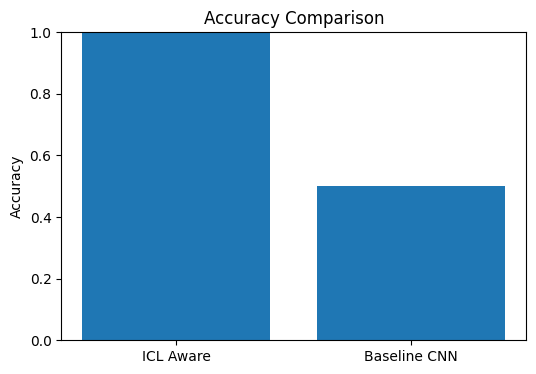


=== ICL ===
True Positive : 5
False Positive: 0
False Negative: 0
True Negative : 5

=== Baseline CNN ===
True Positive : 5
False Positive: 5
False Negative: 0
True Negative : 0


In [ ]:
#@title **Comparing ICL(annotation aware and agnostic) vs Baseline Model**

import pandas as pd

# Convert to DataFrames
df_icl = pd.DataFrame(icl_results)
df_baseline = pd.DataFrame(baseline_results)

# Merge by image name
comparison = df_icl.merge(df_baseline, on="image", suffixes=("_icl", "_baseline"))

display(comparison)

# Compute accuracy
acc_icl = comparison["correct_icl"].mean()
acc_base = comparison["correct_baseline"].mean()

print(f"\nICL Accuracy: {acc_icl:.3f}")
print(f"Baseline Accuracy: {acc_base:.3f}")

# Bar Chart Comparison
plt.figure(figsize=(6,4))
plt.bar(["ICL Aware", "Baseline CNN"], [acc_icl, acc_base])
plt.ylim(0,1)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Confusion Matrix Option
from sklearn.metrics import confusion_matrix

y_true = comparison["true_baseline"].map({"Good":1,"Bad":0})

def print_confusion_stats(cm, title="Confusion Matrix"):
    TN, FP, FN, TP = cm.ravel()

    print(f"\n=== {title} ===")
    print(f"True Positive : {TP}")
    print(f"False Positive: {FP}")
    print(f"False Negative: {FN}")
    print(f"True Negative : {TN}")

cm_icl = confusion_matrix(y_true, comparison["pred_icl"].map({"Good":1,"Bad":0}))
cm_base = confusion_matrix(y_true, comparison["pred_baseline"].map({"Good":1,"Bad":0}))

print_confusion_stats(cm_icl, "ICL")
print_confusion_stats(cm_base, "Baseline CNN")

# **Summary**

This demo illustrates how LLMs can perform ICL for binary image classification, using hazelnuts as the target task. By providing the model with a small set of annotated image–label pairs, we show that it can infer the visual distinctions between “Good” and “Bad” hazelnuts—such as cracks, surface irregularities, or discoloration—without ever being trained as a model for this specific purpose.

To ground the evaluation, we compare the LLM’s classification behavior against a traditional Convolutional Neural Network (CNN) baseline trained directly on the pixel data. The CNN provides a fully supervised reference point, learning visual features from scratch and offering a stable benchmark for accuracy. When evaluated across a set of unseen test images, ICL performs better than the baseline CNN and achieves a higher accuracy, by classifying all the test images correct. Even if we increase the number of epochs the CNN was trained on, the amount of training data was still not enough for the baseline to classify the hazelnuts correctly

The techniques demonstrated here can be extended beyond hazelnut inspection to a broad range of lightweight image-based classification tasks. With a small set of curated examples, LLMs can be prompted to generalize visual patterns related to binary categories: quality control, medical triage, material defects, etc. These results highlight how ICL can provide quick, adaptable classification capabilities without the need to train or fine-tune a neural network, significantly reducing computational costs and setup time.

## **Conclusion**

This demonstration shows that LLMs can perform meaningful visual classification through pattern recognition alone—interpreting defects in hazelnut images using only the examples supplied in the prompt. The ICL approach allows for stronger generalization from very small datasets (10 images). Compared to the CNN baseline, ICL performs better and more consistent, proving that the LLM’s flexibility and ability to mimic a human-like pattern learning skill. Together, the comparison between ICL and the CNN baseline offers a clear perspective on why LLMs are capable of excelling in tasks that normally would take traditional approaches much more time to retrain and larger datasets that would need to be used.